# Creating vector representations of SEU Neuron Morphologies

In [65]:
import getpass
import json
import jwt
import pickle
import sys

from os import listdir
from os.path import isfile, join

from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from kgforge.core import KnowledgeGraphForge
from kgforge.specializations.resources import Dataset

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from bluegraph import PandasPGFrame
from bluegraph.preprocess import ScikitLearnPGEncoder
from bluegraph.downstream.utils import transform_to_2d, plot_2d
from bluegraph.preprocess import CooccurrenceGenerator
from bluegraph.backends.gensim import GensimNodeEmbedder
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder
from bluegraph.backends.networkx import NXCommunityDetector
from bluegraph.downstream import EmbeddingPipeline
from bluegraph.downstream.similarity import (FaissSimilarityIndex, ScikitLearnSimilarityIndex,
                                             SimilarityProcessor)
from bluegraph import version as bg_version

import morphio
import tmd.io
import tmd.Neuron
import tmd.utils
from tmd.Topology.methods import get_ph_neuron

%matplotlib inline

## Helpers

In [66]:
def get_encoder_features(prop_name, encoder, last_index):
    if encoder is None or isinstance(encoder, StandardScaler):
        return {last_index: f"{prop_name}_IDENTITY"}, last_index + 1
    if isinstance(encoder, TfidfVectorizer):
        return (
            {
                i + last_index: f"{prop_name}_WORD_{f}"
                for i, f in enumerate(encoder.get_feature_names())
            },
            last_index + len(encoder.get_feature_names())
        )
    elif isinstance(encoder, MultiLabelBinarizer):
        return (
            {
                i + last_index: f"{prop_name}_CLASS_{c}"
                for i, c in enumerate(encoder.classes_)
            },
            last_index + len(encoder.classes_)
        )
    
    else:
        return {}, last_index


def explain_property_coordinates(encoder, graph):
    last_index = 0
    property_coordinates = {}
    for p in graph.node_properties():
        if p in encoder._node_encoders:
            res, new_index = get_encoder_features(
                p, encoder._node_encoders[p], last_index)
            property_coordinates.update(res)
            last_index = new_index
    return property_coordinates


def get_neurom_feature_annotations(data, compartments_to_exclude, statistics_of_interest):
    record = {}
    try:
        for ann in data.annotation:
            if "MType:Annotation" in ann["type"]:
                record["MType"] = ann["hasBody"]["label"]
            if "NeuronMorphologyFeatureAnnotation" in ann["type"]:
                compartment = ann["compartment"]
                if compartment not in compartments_to_exclude:
                    for feature_ann in ann["hasBody"]:
                        if "NeuriteLocationFeature" not in feature_ann["type"]:
                            feature_name = feature_ann["isMeasurementOf"]["label"].replace(" ", "_")
                            if isinstance(feature_ann["series"], dict):
                                feature_ann["series"] = [feature_ann["series"]]
                            for el in feature_ann["series"]:
                                if "statistic" in el:
                                    stat = el["statistic"].replace(" ", "_")
                                    if stat in statistics_of_interest and "value" in el:
                                        record[f"{compartment}_{stat}_{feature_name}"] = el["value"]
    except TypeError:
        pass
    return record


def get_notation(region_id, brain_region_notation):
    if region_id not in brain_region_notation:
        r = forge.retrieve(region_id)
        brain_region_notation[r.id] = (r.notation, r.prefLabel)
    return brain_region_notation[region_id][0]


def get_location_feature_annotations(data, compartments_to_exclude, brain_region_notation):
    record = {}
    try:
        for ann in data.annotation:
            if "MType:Annotation" in ann["type"]:
                record["MType"] = ann["hasBody"]["label"]
            if "NeuronMorphologyFeatureAnnotation" in ann["type"]:
                compartment = ann["compartment"]
                if compartment not in compartments_to_exclude:
                    for feature_ann in ann["hasBody"]:
                        if "NeuriteLocationFeature" in feature_ann["type"]:
                            feature_name = feature_ann["isMeasurementOf"]["label"].replace(" ", "_")
                            if isinstance(feature_ann["series"], dict):
                                feature_ann["series"] = [feature_ann["series"]]
                            regions = sum([
                                [get_notation(
                                    r["brainRegion"]["id"],
                                    brain_region_notation)] * r["count"]
                                for r in feature_ann["series"]
                            ], [])
                            record[f"{compartment}_{feature_name}"] = regions
                            
    except TypeError as e:
        pass
    return record


def get_agent(token):
    agent_data = jwt.decode(token, verify=False)
    agent = forge.reshape(
        forge.from_json(agent_data), keep=[
            "name", "email", "sub", "preferred_username"])
    agent.id = agent.sub
    agent.type = "Person"
    return agent


def register_model(forge, agent, name, description, label, distribution, similarity, dimension):
    # Create a new model resource
    model_resource = Dataset(
        forge,
        name=name,
        description=description)
    model_resource.type = "EmbeddingModel"
    model_resource.prefLabel = label
    model_resource.similarity = similarity
    model_resource.vectorDimension = dimension

    # Add distrubution
    if distribution is not None:
        model_resource.add_distribution(
            distribution, content_type="application/octet-stream")

    # Add contribution
    model_resource.add_contribution(agent, versioned=False)
    role = forge.from_json({
        "hadRole": {
            "id": "http://purl.obolibrary.org/obo/CRO_0000064",
            "label": "software engineering role"
        }
    })
    model_resource.contribution.hadRole = role

    # Add software agent
    software_agent = {
        "type": "SoftwareAgent",
        "description": "Unifying Python framework for graph analytics and co-occurrence analysis.",
        "name": "BlueGraph",
        "softwareSourceCode": {
            "type": "SoftwareSourceCode",
            "codeRepository": "https://github.com/BlueBrain/BlueGraph",
            "programmingLanguage": "Python",
            "runtimePlatform": f"{sys.version_info.major}.{sys.version_info.minor}",
            "version": bg_version.__version__
        }
    }
    model_resource.wasAssociatedWith = software_agent
    
    forge.register(model_resource)
    return model_resource.id


def update_model_distribution(forge, model_resource, new_distribution, vector_dim=None):
    if vector_dim is not None:
        model_resource.vectorDimension = vector_dim
    model_resource.distribution = forge.attach(new_distribution, content_type="application/octet-stream")
    forge.update(model_resource)
    

def push_model(forge, agent, name, description, label, distribution, similarity, dimension):
    result = forge.search({"name": name})
    if result:
        print("Model exists, updating...")
        model_resource = result[0]
        update_model_distribution(forge, model_resource, distribution, dimension)
    else:
        print("Registering new model...")
        register_model(forge, agent, name, description, label, distribution, similarity, dimension)


def plot_diagram(diagram, max_value=None):
    positive = np.array([
        [s, e]
        for s, e in diagram
        if s <= e
    ])
    negative = np.array([
        [s, e]
        for s, e in diagram
        if s >= e
    ])
    births = [el[0] for el in diagram]
    if max_value is not None:
        births.append(max_value)
    f, ax = plt.subplots(figsize=(5, 5))
    if positive.shape[0] != 0:
        ax.scatter(np.array(positive)[:,0], np.array(positive)[:,1])
    if negative.shape[0] != 0:
        ax.scatter(np.array(negative)[:,0], np.array(negative)[:,1])
    ax.plot(births, births)
    plt.show()


def diagram_to_persistance_points(diagram):
    lower_points = np.array([
        [s, s - t] for s, t in diagram if s >= t
    ])
    upper_points = np.array([
        [s, t - s] for s, t in diagram if s <= t
    ])
    return lower_points, upper_points


def kernel_density(x, centers, masses, kernel_width):
    density = np.sum(
        masses * np.exp(- (2 * kernel_width) ** -2 * (x - centers) ** 2))
    return density


def evaluate_composed_density(points, x, width):
    centers = points[:, 0]
    masses = points[:, 1]
    return np.array([kernel_density(el, centers, masses, width) for el in x])


def compute_persistance_vector(diagram, dim, max_time, kernel_width):
    if not dim % 2:
        lower_dim = upper_dim = int(dim / 2)
    else:
        lower_dim = int(dim / 2) + 1
        upper_dim = dim - lower_dim
    
    lower_points, upper_points = diagram_to_persistance_points(diagram)

    if lower_points.shape[0] == 0:
        lower_vector = np.zeros(lower_dim)
    else:
        lower_vector = evaluate_composed_density(
            lower_points, np.linspace(0, max_time, num=lower_dim), kernel_width)
    if upper_points.shape[0] == 0:
        upper_vector = np.zeros(upper_dim)
    else:
        upper_vector = evaluate_composed_density(
            upper_points, np.linspace(0, max_time, num=upper_dim), kernel_width)
    return np.concatenate([lower_vector, upper_vector])


def plot_diagram_profile(diagram, max_time, width, ylim):
    plot_diagram(diagram, max_value=max_time)
    plt.show()

    lower_points, upper_points = diagram_to_persistance_points(diagram)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if lower_points.shape[0] != 0:
        xvals = np.arange(0, max_time, max_time / 200)
        lower_density = evaluate_composed_density(
            lower_points, xvals, width)
        
        ax1.plot(xvals, lower_density)
        ax1.scatter(lower_points[:, 0], lower_points[:, 1])
        ax1.set_ylim((0, ylim))

    if upper_points.shape[0] != 0:
        xvals = np.arange(0, max_time, max_time / 200)
        upper_density = evaluate_composed_density(
            upper_points, xvals, width)
        ax2.plot(xvals, upper_density)
        ax2.scatter(upper_points[:, 0], upper_points[:, 1])
        ax2.set_ylim((0, ylim))
    plt.show()
    
    
def load_morphologies(paths, progress_bar=iter):
    """Author: Stanislav Schmidt"""
    morphs = {}
    errors = {}
    for file in progress_bar(paths):
        try:
            morphology = morphio.Morphology(
                file,
                morphio.Option.soma_sphere,
            )
        except morphio.MorphioError as exc:
            errors[file] = str(exc)
        else:
            morphs[file] = morphology

    return morphs, errors


def to_tmd_neuron(morphology: morphio.Morphology) -> tmd.Neuron.Neuron:
    """Convert a MorphIO neuron to a TMD neuron.
    
    Author: Stanislav Schmidt
    """
    neuron = tmd.Neuron.Neuron()
    for tree in tmd.io.convert_morphio_trees(morphology):
        neuron.append_tree(tree, tmd.utils.TREE_TYPE_DICT)

    return neuron


def get_persistence_data(neuron):
    """Author: Stanislav Schmidt"""
    if neurite_type is None:
        kind = "all"
    else:
        kind = neurite_type.name
    ph = get_ph_neuron(neuron, neurite_type=kind)
    ph_arr = np.array(ph)
    return ph_arr

# I. Prepare morphology data

## 1. Load morphologies from Nexus 

In [67]:
TOKEN = getpass.getpass()

········


In [68]:
forge = KnowledgeGraphForge("../../configs/new-forge-config.yaml",
                            token=TOKEN,
                            bucket="bbp-external/seu")

In [69]:
query = """
    SELECT ?id
    WHERE {
        ?id a NeuronMorphology ;
            <https://bluebrain.github.io/nexus/vocabulary/deprecated> false .
    }
""" 

resources = forge.sparql(query, limit=1500)
morphologies = [forge.retrieve(r.id) for r in resources] 

In [70]:
full_df = forge.as_dataframe(morphologies)

## 2. Extract neurite features (NeuroM features)

Build a data frame with neurite features (per neurite). At the moment we ignore 'ApicalDendrite' and take only mean and std for each feature computed by NeuroM.

In [71]:
EXCLUDE_COMPARTMENTS = ["ApicalDendrite"]
STATISTICS_OF_INTEREST = ["mean", "standard_deviation"]

In [72]:
neurite_feature_df = pd.DataFrame(full_df.apply(
    lambda x: get_neurom_feature_annotations(
        x, EXCLUDE_COMPARTMENTS, STATISTICS_OF_INTEREST), axis=1).tolist())

In [73]:
print("Including the following neurite features:")
for n in neurite_feature_df.columns:
    print("\t", n)

Including the following neurite features:
	 Axon_mean_Neurite_Max_Radial_Distance
	 Axon_standard_deviation_Neurite_Max_Radial_Distance
	 Axon_mean_Number_Of_Sections
	 Axon_standard_deviation_Number_Of_Sections
	 Axon_mean_Number_Of_Bifurcations
	 Axon_standard_deviation_Number_Of_Bifurcations
	 Axon_mean_Number_Of_Leaves
	 Axon_standard_deviation_Number_Of_Leaves
	 Axon_mean_Total_Length
	 Axon_standard_deviation_Total_Length
	 Axon_mean_Total_Area
	 Axon_standard_deviation_Total_Area
	 Axon_mean_Total_Volume
	 Axon_standard_deviation_Total_Volume
	 Axon_mean_Section_Lengths
	 Axon_standard_deviation_Section_Lengths
	 Axon_mean_Section_Term_Lengths
	 Axon_standard_deviation_Section_Term_Lengths
	 Axon_mean_Section_Bif_Lengths
	 Axon_standard_deviation_Section_Bif_Lengths
	 Axon_mean_Section_Branch_Orders
	 Axon_standard_deviation_Section_Branch_Orders
	 Axon_mean_Section_Bif_Branch_Orders
	 Axon_standard_deviation_Section_Bif_Branch_Orders
	 Axon_mean_Section_Term_Branch_Orders
	 Axo

In [74]:
neurite_feature_df

,Axon_mean_Neurite_Max_Radial_Distance,Axon_standard_deviation_Neurite_Max_Radial_Distance,Axon_mean_Number_Of_Sections,Axon_standard_deviation_Number_Of_Sections,Axon_mean_Number_Of_Bifurcations,Axon_standard_deviation_Number_Of_Bifurcations,Axon_mean_Number_Of_Leaves,Axon_standard_deviation_Number_Of_Leaves,Axon_mean_Total_Length,Axon_standard_deviation_Total_Length,...,NeuronMorphology_mean_Total_Area_Per_Neurite,NeuronMorphology_standard_deviation_Total_Area_Per_Neurite,NeuronMorphology_mean_Total_Volume_Per_Neurite,NeuronMorphology_standard_deviation_Total_Volume_Per_Neurite,NeuronMorphology_mean_Number_Of_Neurites,NeuronMorphology_standard_deviation_Number_Of_Neurites,Soma_mean_Soma_Surface_Area,Soma_standard_deviation_Soma_Surface_Area,Soma_mean_Soma_Radius,Soma_standard_deviation_Soma_Radius
0,4128.578613,4128.578613,451.0,451.0,225.0,225.0,226.0,226.0,46646.833876,46646.833876,...,45703.575805,93766.319566,24333.741158,46428.788471,8.0,8.0,828.702414,828.702414,8.120717,8.120717
1,3364.643311,3364.643311,219.0,219.0,109.0,109.0,110.0,110.0,25101.206810,25101.206810,...,32249.298571,56263.961954,16683.966274,27914.475891,6.0,6.0,320.297982,320.297982,5.048614,5.048614
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,44966.880444,87078.691819,23020.274457,43461.267018,6.0,6.0,391.450836,391.450836,5.581278,5.581278
3,2837.244873,2837.244873,331.0,331.0,165.0,165.0,166.0,166.0,30027.558500,30027.558500,...,27680.194047,60906.465352,14232.720855,30317.305664,8.0,8.0,536.995242,536.995242,6.537027,6.537027
4,3355.316650,3355.316650,235.0,235.0,117.0,117.0,118.0,118.0,35852.890493,35852.890493,...,29045.213814,69431.373375,15076.814074,34536.556828,9.0,9.0,417.342855,417.342855,5.762906,5.762906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1004.798218,1004.798218,209.0,209.0,104.0,104.0,105.0,105.0,39278.780528,39278.780528,...,40809.524452,84290.137670,20913.943568,41977.551572,7.0,7.0,141.584060,141.584060,3.356621,3.356621
396,1749.600708,1749.600708,193.0,193.0,96.0,96.0,97.0,97.0,46355.535309,46355.535309,...,46887.418318,100198.292736,24412.777087,49913.019596,7.0,7.0,181.329941,181.329941,3.798655,3.798655
397,5185.719238,5185.719238,353.0,353.0,176.0,176.0,177.0,177.0,53163.896261,53163.896261,...,47035.365333,102767.863733,26171.298928,51579.494322,9.0,9.0,502.749888,502.749888,6.325153,6.325153
398,5408.804688,5408.804688,279.0,279.0,139.0,139.0,140.0,140.0,57235.094892,57235.094892,...,71153.951087,129643.898775,40682.452968,63335.629674,6.0,6.0,318.100518,318.100518,5.031266,5.031266


## 3. Extract location-based features (section/leaf regions).

In [75]:
forge = KnowledgeGraphForge(
    "../../configs/new-forge-config.yaml",
    token=TOKEN,
    bucket="neurosciencegraph/datamodels")

In [76]:
brain_region_resources = [
    forge.retrieve(el) for el in full_df["brainLocation.brainRegion.id"]
]
brain_region_notation = {
    r.id: (r.notation, r.prefLabel)
    for r in brain_region_resources
}

In [77]:
localization_features = pd.DataFrame(full_df.apply(
    lambda x: get_location_feature_annotations(
        x, EXCLUDE_COMPARTMENTS, brain_region_notation), axis=1).tolist())

In [78]:
localization_features.sample(5)

,Axon_Section_Regions,Axon_Leaf_Regions,BasalDendrite_Section_Regions,BasalDendrite_Leaf_Regions
118,"[or, or, or, or, or, or, or, or, or, or, or, o...","[AUDv6a, AUDv6a, SSs5, SSs5, SSs5, SSs5, SSs6a...","[or, or, or, or, or, or, or, or, or, or, or, o...","[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ..."
173,"[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ...","[RT, RT, RT, RT, int, int, int, int, int, int,...","[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ...","[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ..."
35,"[LGd-co, LGd-co, LGd-co, LGd-co, LGd-co, LGd-c...","[root, root, root, fiber tracts, fiber tracts,...","[LGd-co, LGd-co, LGd-co, LGd-co, LGd-co, LGd-c...","[LGd-co, LGd-co, LGd-co, LGd-co, LGd-co, LGd-c..."
253,"[VISa2/3, VISa2/3, VISa2/3, VISa2/3, VISa2/3, ...","[VISa1, VISa1, VISa1, VISa2/3, VISa2/3, VISa2/...","[VISa2/3, VISa2/3, VISa2/3, VISa2/3, VISa2/3, ...","[VISam2/3, VISam2/3, VISam2/3, VISam2/3, VISam..."
241,"[MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/...","[MOp5, MOp5, MOp5, MOp5, MOp5, MOp5, MOp5, MOp...","[MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/...","[MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/3, MOp2/..."


## 4. Build a data frame with the rest of the meta-data

In [79]:
morphologies_df = full_df[[
    "id",
    "brainLocation.brainRegion.id",
    "somaNumberOfPoints.value"
]]

In [80]:
morphologies_df["brainLocation.brainRegion.id"] = morphologies_df["brainLocation.brainRegion.id"].apply(
    lambda x: brain_region_notation[x][0])

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
morphologies_df.sample(3)

,id,brainLocation.brainRegion.id,somaNumberOfPoints.value
112,https://bbp.epfl.ch/neurosciencegraph/data/neu...,VPM,3.0
121,https://bbp.epfl.ch/neurosciencegraph/data/neu...,VPM,3.0
285,https://bbp.epfl.ch/neurosciencegraph/data/neu...,ACAv,3.0


# II. Create different representations of morphologies

## 1. Create axon/dendrite co-projection property graphs

We build two property graphs: 
- axon co-projection graph
- dendrite co-occurrence

We use meta-data as node properties.

In [82]:
nodes = pd.concat(
    [morphologies_df, localization_features], axis=1).rename(
    columns={"id": "@id"}).set_index("@id")

In [83]:
nodes.sample(3)

,brainLocation.brainRegion.id,somaNumberOfPoints.value,Axon_Section_Regions,Axon_Leaf_Regions,BasalDendrite_Section_Regions,BasalDendrite_Leaf_Regions
@id,,,,,,
https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/48919d9f-7901-4e35-bc08-9c89632f2201,SSs,3.0,"[SSs1, SSs1, SSs1, SSs1, SSs1, SSs1, SSs1, SSs...","[AUDd1, AUDd1, AUDd1, AUDd1, AUDd1, AUDd1, AUD...","[SSs1, SSs1, SSs1, SSs1, SSs1, SSs1, SSs1, SSs...","[AUDd1, AUDd1, SSs1, SSs1, SSs1, SSs1, SSs1, S..."
https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/1a0f6629-b881-40fe-a85b-d277eab7922b,VPM,3.0,"[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ...","[RT, RT, RT, RT, RT, RT, RT, RT, RT, RT, RT, R...","[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ...","[VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, VPM, ..."
https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/0739d5ad-0107-45c5-8831-f6f7b9d98340,ORBm,3.0,"[ORBm2/3, ORBm2/3, ORBm2/3, ORBm2/3, ORBm2/3, ...","[ORBm5, ORBm5, ORBm5, ORBm5, ORBm5, ORBm5, ORB...","[ORBm2/3, ORBm2/3, ORBm2/3, ORBm2/3, ORBm2/3, ...","[ORBm1, ORBm1, ORBm1, ORBm1, ORBm1, ORBm2/3, O..."


In [84]:
nodes.columns

Index(['brainLocation.brainRegion.id', 'somaNumberOfPoints.value',
       'Axon_Section_Regions', 'Axon_Leaf_Regions',
       'BasalDendrite_Section_Regions', 'BasalDendrite_Leaf_Regions'],
      dtype='object')

In [85]:
frame = PandasPGFrame()
frame._nodes = nodes
numerical_props = ['somaNumberOfPoints.value']

for column in nodes.columns:
    if column != "@type":
        if column not in numerical_props:
            try:
                frame.node_prop_as_category(column)
            except ValueError:
                pass
        else:
            frame.node_prop_as_numeric(column)
frame.rename_node_properties({
    p: p.replace(".", "_")
    for p in frame.node_properties()
})

In [88]:
# nodes_to_remove = list(frame._nodes[frame._nodes["Axon_Leaf_Regions"].isna()].index)
# frame.remove_nodes(nodes_to_remove)

Encode properties into vectors

In [89]:
props = set(frame.node_properties()).difference({
    "Axon_Section_Regions",
    "Axon_Leaf_Regions",
    "BasalDendrite_Section_Regions",
    "BasalDendrite_Leaf_Regions"})
encoder = ScikitLearnPGEncoder(
    node_properties=props,
    missing_numeric="impute",
    imputation_strategy="mean",
    reduce_node_dims=True,
    n_node_components=40)

In [90]:
encoded_frame = encoder.fit_transform(frame)

Explained variance of data

In [91]:
sum(encoder.node_reducer.explained_variance_ratio_)

0.9855724598179626

### Generate the axon co-projection graph

In [92]:
gen = CooccurrenceGenerator(frame)
axon_edges = gen.generate_from_nodes(
    "Axon_Leaf_Regions",
    compute_statistics=["frequency"])

In [93]:
axon_edges = axon_edges[axon_edges["frequency"].values > 10]

In [94]:
axon_edges.shape

(17857, 2)

In [95]:
axon_coprojection_frame = PandasPGFrame.from_frames(
    nodes=encoded_frame._nodes, edges=axon_edges)
axon_coprojection_frame.edge_prop_as_numeric("frequency")

In [96]:
len(axon_coprojection_frame.isolated_nodes())

4

### Generate the dendrite co-projection graph

In [97]:
gen = CooccurrenceGenerator(frame)
dendrite_edges = gen.generate_from_nodes(
    "BasalDendrite_Leaf_Regions",
    compute_statistics=["frequency"])

In [98]:
dendrite_edges.shape

(9028, 2)

In [99]:
dendrite_coprojection_frame = PandasPGFrame.from_frames(
    nodes=encoded_frame._nodes, edges=dendrite_edges)
dendrite_coprojection_frame.edge_prop_as_numeric("frequency")

In [100]:
len(dendrite_coprojection_frame.isolated_nodes())

8

### Perform axon co-projection graph embedding

In [101]:
axon_D = 128

In [102]:
axon_embedder = StellarGraphNodeEmbedder(
    "node2vec", length=5, number_of_walks=20,
    epochs=5, embedding_dimension=axon_D, edge_weight="frequency",
    random_walk_p=2, random_walk_q=0.2)
axon_embedding = axon_embedder.fit_model(axon_coprojection_frame)

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


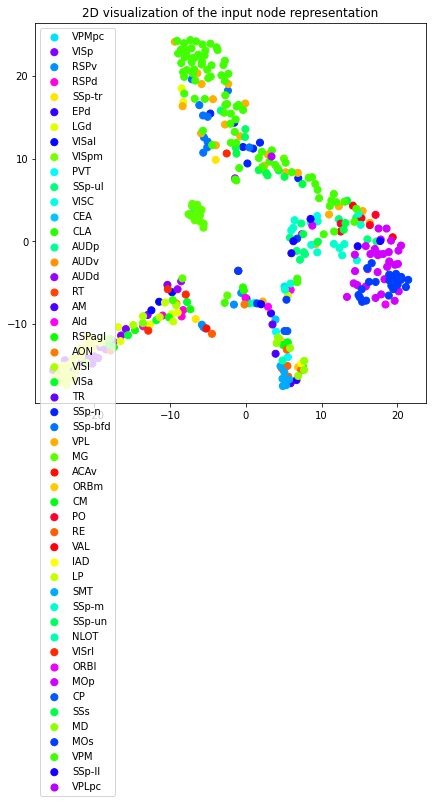

In [103]:
axon_coprojection_frame.add_node_properties(
    axon_embedding.rename(columns={"embedding": "node2vec"}))
embedding_2d = transform_to_2d(axon_coprojection_frame._nodes["node2vec"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

Create and save the pipeline

In [104]:
similarity_index = FaissSimilarityIndex(
    dimension=axon_D, similarity="cosine", n_segments=3)
sim_processor = SimilarityProcessor(similarity_index)
sim_processor.add(
    axon_embedding["embedding"].tolist(),
    axon_embedding.index)

pipeline = EmbeddingPipeline(
    embedder=axon_embedder,
    similarity_processor=sim_processor)

pipeline.save("../../data/SEU_morph_axon_coproj_node2vec_cosine", compress=True)

<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd888ddfdb0> >


/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/downstream/similarity.py:180: SimilarityWarning: Faiss segmented index is not trained, training on the provided vectors
  SimilarityIndex.SimilarityWarning)


### Perform dendrite co-occurrence graph embedding

In [105]:
dendrite_D = 100

In [106]:
dendrite_embedder = StellarGraphNodeEmbedder(
    "node2vec", length=5, number_of_walks=20,
    epochs=5, embedding_dimension=dendrite_D, edge_weight="frequency",
    random_walk_p=2, random_walk_q=0.2)
dendrite_embedding = dendrite_embedder.fit_model(dendrite_coprojection_frame)

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


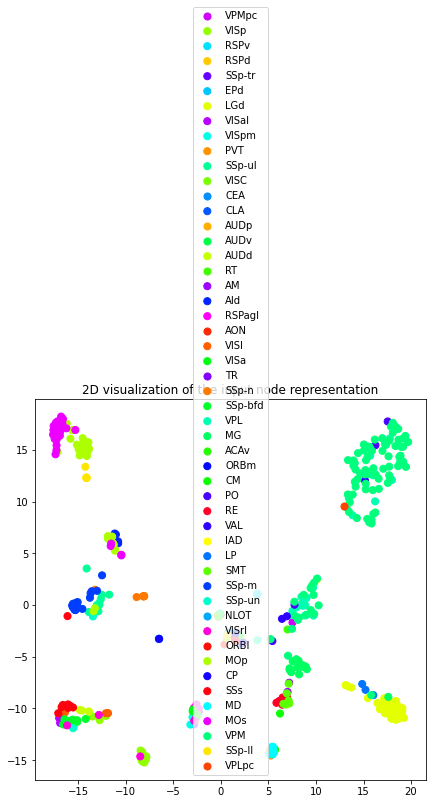

In [107]:
dendrite_coprojection_frame.add_node_properties(
    dendrite_embedding.rename(columns={"embedding": "node2vec"}))
embedding_2d = transform_to_2d(dendrite_coprojection_frame._nodes["node2vec"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

Create and save the pipeline

In [108]:
similarity_index = FaissSimilarityIndex(
    dimension=dendrite_D, similarity="cosine", n_segments=3)
sim_processor = SimilarityProcessor(similarity_index)
sim_processor.add(
    dendrite_embedding["embedding"].tolist(),
    dendrite_embedding.index)

pipeline = EmbeddingPipeline(
    embedder=dendrite_embedder,
    similarity_processor=sim_processor)

pipeline.save("../../data/SEU_morph_dendrite_coproj_node2vec_cosine", compress=True)

<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd87bcb78d0> >


/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/downstream/similarity.py:180: SimilarityWarning: Faiss segmented index is not trained, training on the provided vectors
  SimilarityIndex.SimilarityWarning)


## 2. Create coordinate vectors

In [109]:
coordinate_df = pd.DataFrame(morphologies_df["id"])

In [110]:
coordinate_df["coordinates"] = pd.Series(full_df[[
    "brainLocation.coordinatesInBrainAtlas.valueX.value",
    "brainLocation.coordinatesInBrainAtlas.valueY.value",
    "brainLocation.coordinatesInBrainAtlas.valueZ.value"
]].values.tolist()).apply(lambda x: [float(el) for el in x])
coordinate_df = coordinate_df.rename(columns={"id": "@id"})

Scale coordinates by dividing by the maximum value

In [111]:
coordinates = np.array(coordinate_df["coordinates"].tolist())
coordinate_df["coordinates"] = (coordinates / coordinates.max()).tolist()

In [112]:
coordinate_df = coordinate_df.set_index("@id")

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


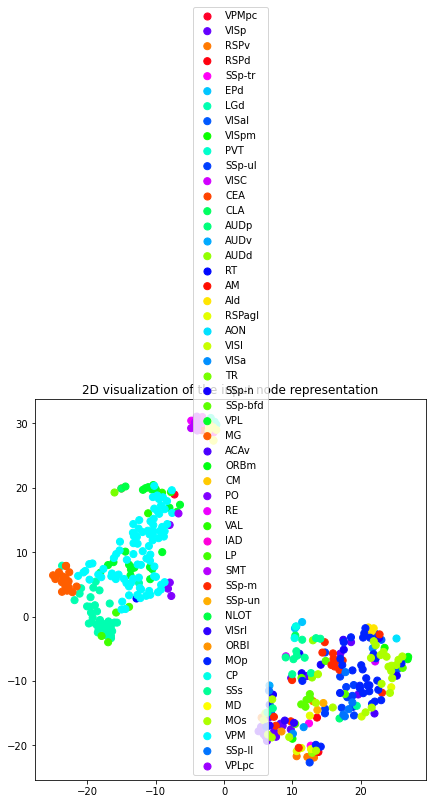

In [113]:
embedding_2d = transform_to_2d([[float(v) for v in el] for el in coordinate_df["coordinates"].tolist()])
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

In [114]:
coordinates_frame = PandasPGFrame.from_frames(
    nodes=coordinate_df, edges=pd.DataFrame())

In [115]:
similarity_index = FaissSimilarityIndex(
    dimension=3, similarity="euclidean", n_segments=3)
sim_processor = SimilarityProcessor(similarity_index)
sim_processor.add(coordinate_df["coordinates"].tolist(),
                  coordinate_df.index)
pipeline = EmbeddingPipeline(
    preprocessor=None,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("../../data/SEU_morph_coordinates_euclidean", compress=True)

<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd8153cb180> >


/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/downstream/similarity.py:180: SimilarityWarning: Faiss segmented index is not trained, training on the provided vectors
  SimilarityIndex.SimilarityWarning)


## 3. Create neurite feature vectors

In [116]:
neurite_features = pd.concat([nodes.reset_index()["@id"], neurite_feature_df], axis=1).set_index("@id")

In [117]:
neurite_frame = PandasPGFrame.from_frames(
    nodes=neurite_features, edges=pd.DataFrame())

In [118]:
for c in neurite_frame._nodes.columns:
    try:
        neurite_frame.node_prop_as_numeric(c)
    except:
        neurite_frame.node_prop_as_category(c)

In [119]:
encoder = ScikitLearnPGEncoder(
    node_properties=neurite_frame.node_properties(),
    missing_numeric="impute",
    imputation_strategy="mean")
encoded_frame = encoder.fit_transform(neurite_frame)

In [120]:
neurite_features = encoded_frame._nodes.rename(
    columns={"features": "neurite_features"})

In [121]:
data = np.array(neurite_features["neurite_features"].tolist())
neurite_features["neurite_features"] = (data / data.max()).tolist()

In [122]:
neurite_dim = len(neurite_features["neurite_features"].iloc[0])

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


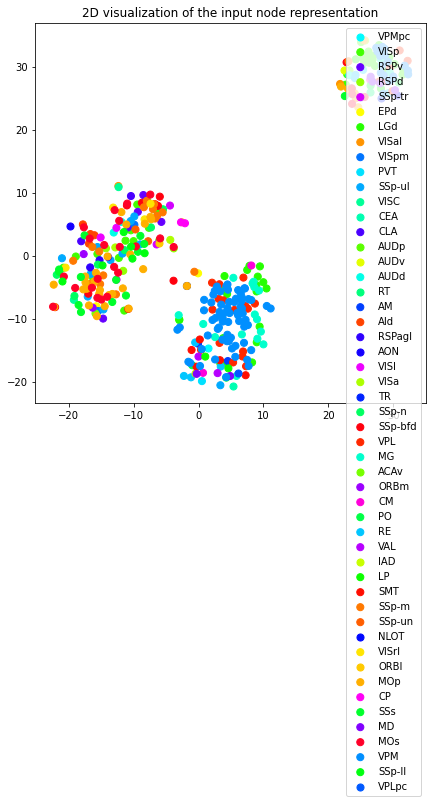

In [123]:
embedding_2d = transform_to_2d(encoded_frame._nodes["features"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

In [124]:
similarity_index = FaissSimilarityIndex(
    dimension=neurite_dim, similarity="euclidean", n_segments=3)
sim_processor = SimilarityProcessor(similarity_index)
sim_processor.add(neurite_features["neurite_features"].tolist(),
                  neurite_features.index)
pipeline = EmbeddingPipeline(
    preprocessor=encoder,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("../../data/SEU_morph_neurite_features_euclidean", compress=True)

<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd877721360> >


/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/downstream/similarity.py:180: SimilarityWarning: Faiss segmented index is not trained, training on the provided vectors
  SimilarityIndex.SimilarityWarning)


## 4. Perform ontology-based hierarchical brain region embedding

Load Allen CCF v3 Mouse Brain Atlas

In [125]:
with open("../../data/1.json", "r") as f:
    allen_hierarchy = json.load(f)

In [126]:
allen_hierarchy = allen_hierarchy["msg"]

Create a property graph from the loaded hierarchy

In [127]:
def _get_children(hierarchy, edges, father=None):
    for child in hierarchy['children']:
        acronym = child["acronym"]
        if father:
            edges.append((acronym, father))
        _get_children(child, edges, acronym)

allen_edges = []
_get_children(allen_hierarchy[0], allen_edges)

In [128]:
nodes = list(set([
    s for el in allen_edges for s in el
]))

In [129]:
allen_ccfv3_frame = PandasPGFrame()
allen_ccfv3_frame.add_nodes(nodes)
allen_ccfv3_frame.add_edges(allen_edges)

Train a Poincare embedding model for the hierarchy

In [130]:
embedder = GensimNodeEmbedder("poincare", size=32, negative=2, epochs=100)
embedding = embedder.fit_model(allen_ccfv3_frame)

In [131]:
np.savetxt("brain_region_embs.tsv", np.array(embedding["embedding"].tolist()), delimiter="\t")

In [132]:
brain_region_D = embedding["embedding"].iloc[0].shape[0]

In [133]:
df = embedding.reset_index()[["@id"]]
df["label"] = df["@id"]
df.to_csv("brain_region_meta.tsv", sep="\t", index=None)

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


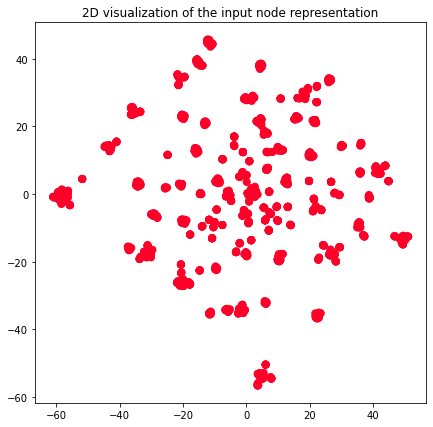

In [134]:
embedding_2d = transform_to_2d(embedding["embedding"].tolist())
plot_2d(allen_ccfv3_frame, vectors=embedding_2d)

In [135]:
brain_region_embedding = frame._nodes["brainLocation_brainRegion_id"].apply(
    lambda x: embedding.loc[x])

In [136]:
brain_region_embedding_frame = PandasPGFrame.from_frames(
    nodes=brain_region_embedding, edges=pd.DataFrame())

In [137]:
similarity_index = ScikitLearnSimilarityIndex(
    dimension=brain_region_D, similarity="euclidean",
    initial_vectors=brain_region_embedding["embedding"].tolist())
sim_processor = SimilarityProcessor(
    similarity_index, brain_region_embedding.index)
pipeline = EmbeddingPipeline(
    preprocessor=None,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("../../data/SEU_morph_brain_region_poincare", compress=True)

## 5. Compute TMD-based embedding (vectorization of persistance diagrams)

In [138]:
DIAGRAMS_DIR = "../../data/persistence_diagrams/"

If you need to recompute persistence diagrams (e.g. new morphs where added or morphs where updated), please, uncomment and run the following cell.

In [139]:
# DOWNLOAD_DIR = "../../data/morphologies/"

# FORMAT = "swc"

# print(f"Downloading {len(morphologies)} morphologies to '{DOWNLOAD_DIR}'...")
# for m in morphologies:
#     for d in m.distribution:
#         if d.name.endswith(f".{FORMAT}"):
#             forge.download(
#                 d, "contentUrl", path=DOWNLOAD_DIR, overwrite=True)
# print("Done.")

# morph_files = [join(DOWNLOAD_DIR, f) for f in listdir(DOWNLOAD_DIR) if isfile(join(DOWNLOAD_DIR, f))]
# morphs, errors = load_morphologies(morph_files)

# neurons = dict()
# failed_morphs = set()
# for path, morph in morphs.items():
#     try:
#         neurons[path] = to_tmd_neuron(morph)
#     except:
#         failed_morphs.add(path)
# print(f"TMD computation failed for {len(failed_morphs)} morphs ({failed_morphs})")

# diagrams = dict()
# for k, v in neurons.items():
#     diagrams[k.split("/")[-1]] = get_persistence_data(v).tolist()
# with open(join(DIAGRAMS_DIR, "persistence_diagrams_all_neurites.json"), "w") as f:
#     json.dump(diagrams, f)

In [140]:
with open(join(DIAGRAMS_DIR, "persistence_diagrams_all_neurites.json"), "r") as f:
    diagram_all_neurites = json.load(f)
    
morphology_files = list(diagram_all_neurites.keys())

In [141]:
# Define some maps from resource uri's and file names (+ brain regions)
names = dict(full_df[["id", "name"]].values)
regions = dict(morphologies_df[["id", "brainLocation.brainRegion.id"]].values)
names_to_regions = {v: regions[k] for k, v in names.items()}
names_to_ids = {v: k for k, v in names.items()}

Compute maximum death/birth time of all diagrams to know the global scale.

In [142]:
all_maxes = []
for d in diagram_all_neurites.values():
    d = np.array(d)
    all_maxes += [d[:,0].max(), d[:,1].max()]
MAX_TIME = max(all_maxes)

### 5.1. Vectorize persisance diagrams as is

In [143]:
dim = 256
WIDTH = 120
MAX_HEIGHT = 17000
vectors = {}
for morph_file, diagram in diagram_all_neurites.items():
#     # Uncomment the following to visualize the vectorization process
#     print(morph_file)
#     plot_diagram_profile(diagram, MAX_TIME, WIDTH, MAX_HEIGHT)
    vectors[morph_file.split(".")[0]] = compute_persistance_vector(diagram, dim, MAX_TIME, WIDTH)
    
keys = list(vectors.keys())
X = np.float32(np.stack([vectors[k] for k in keys]))
print("Shape: ", X.shape)

Shape:  (397, 256)


In [144]:
X = (X / X.max()).tolist()

Visualize the points in 2D

Explained variance:  0.49783525541087725


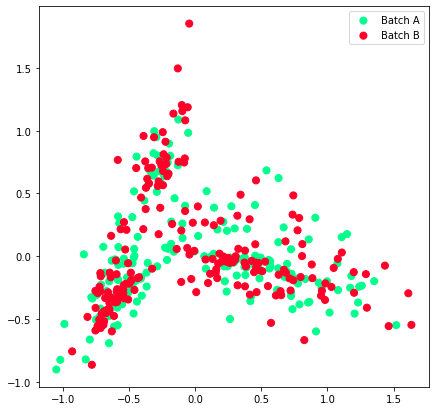

In [145]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
print("Explained variance: ", sum(pca.explained_variance_ratio_))

# labels = np.array([names_to_regions[k] for k in keys])
labels = np.array(["Batch A" for k in keys[:200]] + ["Batch B" for k in keys[200:]])
unique_labels = sorted(list(set(labels)))
cm = plt.get_cmap('gist_rainbow')
generated_colors = np.array([
    cm(1. * i / len(unique_labels))
    for i in range(len(unique_labels))
])
np.random.shuffle(generated_colors)

alpha = 1
fig, ax = plt.subplots(figsize=(7, 7))

# create a scatter per node label
for i, l in enumerate(unique_labels):
    indices = np.where(labels == l)
    ax.scatter(
        X_2d[indices, 0],
        X_2d[indices, 1],
        c=[generated_colors[i]] * indices[0].shape[0],
        s=50,
        label=l
    )
ax.legend()
plt.show()

In [146]:
similarity_index = ScikitLearnSimilarityIndex(
    dimension=dim, similarity="euclidean",
    initial_vectors=X)
sim_processor = SimilarityProcessor(
    similarity_index, [names_to_ids[k] for k in keys])
pipeline = EmbeddingPipeline(
    preprocessor=None,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("../../data/SEU_morph_TMD_euclidean", compress=True)

Actually, for this kind of embeddings, it makes more sense to use [Wasserstein metric](https://en.wikipedia.org/wiki/Wasserstein_metric). See BlueGraph implementation:

In [147]:
# similarity_index = ScikitLearnSimilarityIndex(
#     dimension=dim, similarity="wasserstein",
#     initial_vectors=X)
# sim_processor = SimilarityProcessor(
#     similarity_index, keys)
# pipeline = EmbeddingPipeline(
#     preprocessor=None,
#     embedder=None,
#     similarity_processor=sim_processor)

### 5.2. Scale persisance diagrams before vectorization

Scale each diagram, so that the birth/death time are in the interval [0, 1].

In [148]:
scaled_diagram_all_neurites = {}
for name, diagram in diagram_all_neurites.items():
    diagram = np.array(diagram)
    t_min = diagram.min()
    t_max = diagram.max()
    scaled_diagram_all_neurites[name] = (diagram - t_min) / (t_max - t_min)

In [149]:
SCALED_WIDTH = 0.02
SCALED_MAX_HEIGHT = 7
dim = 256
scaled_vectors = {}
for morph_file, diagram in scaled_diagram_all_neurites.items():
#     # Uncomment the following to visualize the vectorization process
#     print(morph_file)
#     plot_diagram_profile(diagram, 1, SCALED_WIDTH, SCALED_MAX_HEIGHT)
    scaled_vectors[morph_file.split(".")[0]] = compute_persistance_vector(diagram, dim, 1, SCALED_WIDTH)   

In [150]:
keys = list(scaled_vectors.keys())
scaled_X = np.float32(np.stack([scaled_vectors[k] for k in keys]))
print("Shape: ", scaled_X.shape)

Shape:  (397, 256)


In [151]:
scaled_X = (scaled_X / scaled_X.max()).tolist()

Visualize the points in 2D

Explained variance:  0.6174968196471742


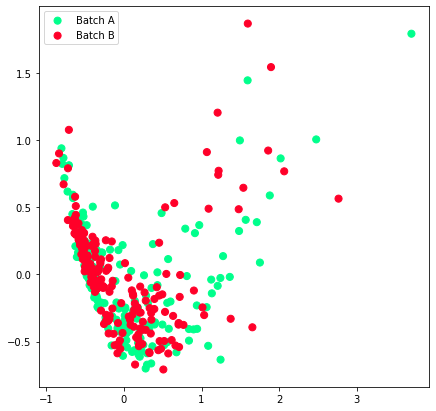

In [152]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(scaled_X)
print("Explained variance: ", sum(pca.explained_variance_ratio_))

# labels = np.array([names_to_regions[k] for k in keys])
labels = np.array(["Batch A" for k in keys[:200]] + ["Batch B" for k in keys[200:]])
unique_labels = sorted(list(set(labels)))
cm = plt.get_cmap('gist_rainbow')
generated_colors = np.array([
    cm(1. * i / len(unique_labels))
    for i in range(len(unique_labels))
])
np.random.shuffle(generated_colors)

alpha = 1
fig, ax = plt.subplots(figsize=(7, 7))

# create a scatter per node label
for i, l in enumerate(unique_labels):
    indices = np.where(labels == l)
    ax.scatter(
        X_2d[indices, 0],
        X_2d[indices, 1],
        c=[generated_colors[i]] * indices[0].shape[0],
        s=50,
        label=l
    )
ax.legend()
plt.show()

In [153]:
similarity_index = ScikitLearnSimilarityIndex(
    dimension=dim, similarity="euclidean",
    initial_vectors=scaled_X)
sim_processor = SimilarityProcessor(
    similarity_index, [names_to_ids[k] for k in keys])
pipeline = EmbeddingPipeline(
    preprocessor=None,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("../../data/SEU_morph_scaled_TMD_euclidean", compress=True)

Actually, for this kind of embeddings, it makes more sense to use [Wasserstein metric](https://en.wikipedia.org/wiki/Wasserstein_metric). See BlueGraph implementation:

In [154]:
# similarity_index = ScikitLearnSimilarityIndex(
#     dimension=dim, similarity="wasserstein",
#     initial_vectors=scaled_X)
# sim_processor = SimilarityProcessor(
#     similarity_index, keys)
# pipeline = EmbeddingPipeline(
#     preprocessor=None,
#     embedder=None,
#     similarity_processor=sim_processor)

# III. Register/update the models into the model catalog

In [155]:
forge = KnowledgeGraphForge(
    "../../configs/new-forge-config.yaml",
    endpoint="https://bbp.epfl.ch/nexus/v1",
    token=TOKEN,
    bucket="dke/embedding-pipelines")

In [156]:
agent = get_agent(TOKEN)

In [157]:
axon_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Axon Co-Projection Embedding",
    "Node embedding model (node2vec) built on an axon co-projection graph extracted from the SEU neuron morphology dataset resources",
    "Axon projection",
    "../../data/SEU_morph_axon_coproj_node2vec_cosine.zip", "cosine",
    axon_D)

Model exists, updating...
<action> _update_one
<succeeded> True


In [158]:
dendrite_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Dendrite Co-Projection Embedding",
    "Node embedding model (node2vec) built on a dendrite co-projection graph extracted from the SEU neuron morphology dataset resources",
    "Dendrite projection",
    "../../data/SEU_morph_dendrite_coproj_node2vec_cosine.zip", "cosine",
    dendrite_D)

Model exists, updating...
<action> _update_one
<succeeded> True


In [159]:
coordinates_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Coordinates",
    "Coordinate similarity of SEU neuron morphology dataset resources",
    "Coordinates",
    "../../data/SEU_morph_coordinates_euclidean.zip", "euclidean",
    3)

Model exists, updating...
<action> _update_one
<succeeded> True


In [160]:
neurite_features_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Neurite Features",
    "Feature encoding model built for neurite features from the SEU neuron morphology dataset resources",
    "Neurite features",
    "../../data/SEU_morph_neurite_features_euclidean.zip", "euclidean", neurite_dim)

Model exists, updating...
<action> _update_one
<succeeded> True


In [161]:
brain_region_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Brain Region Embedding",
    "Poincare node embedding of brain regions in Allen CCFv3 of the SEU neuron morphology dataset resources",
    "Brain regions (CCfv3)",
    "../../data/SEU_morph_brain_region_poincare.zip", "poincare", brain_region_D)

Model exists, updating...
<action> _update_one
<succeeded> True


In [162]:
TMD_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology TMD-based Embedding",
    "Vectorization of scaled persistence diagrams of the SEU neuron morphologies",
    "TMD",
    "../../data/SEU_morph_TMD_euclidean.zip", "euclidean", 256)

Model exists, updating...
<action> _update_one
<succeeded> True


In [163]:
scaled_TMD_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology scaled TMD-based Embedding",
    "Vectorization of scaled persistence diagrams of the SEU neuron morphologies",
    "TMD (scaled)",
    "../../data/SEU_morph_scaled_TMD_euclidean.zip", "euclidean", 256)

Model exists, updating...
<action> _update_one
<succeeded> True
